In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from pathlib import Path
from typing import Any
from logging import INFO, DEBUG
import json
import os
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from scipy.signal import medfilt
from flwr.common import log, ndarrays_to_parameters
import matplotlib.pyplot as plt
import math

from src.common.client_utils import (
    load_femnist_dataset,
    get_network_generator_cnn as get_network_generator,
    get_device,
    get_model_parameters,
    aggregate_weighted_average,
)


from src.flwr_core import (
    set_all_seeds,
    get_paths,
    decompress_dataset,
    get_flower_client_generator,
    sample_random_clients,
    get_federated_evaluation_function,
    create_iid_partition,
)

from src.estimate import (
    compute_critical_batch,
)

from src.experiments_simulation import (
    run_simulation,
    centralized_experiment,
)

from src.utils import get_centralized_acc_from_hist

PathType = Path | str | None

In [17]:
set_all_seeds()

PATHS = get_paths()

HOME_DIR = PATHS["home_dir"]
DATASET_DIR = PATHS["dataset_dir"]
DATA_DIR = PATHS["data_dir"]
CENTRALIZED_PARTITION = PATHS["centralized_partition"]
CENTRALIZED_MAPPING = PATHS["centralized_mapping"]
FEDERATED_PARTITION = PATHS["federated_partition"]
FEDERATED_IID_PARTITION = PATHS["iid_partition"]

# extract dataset from tar.gz
decompress_dataset(PATHS)

In [18]:
max_clients = 1000

In [19]:
create_iid_partition(PATHS, num_clients=max_clients)

Distributing data to client 0
Distributing data to client 1
Distributing data to client 2
Distributing data to client 3
Distributing data to client 4
Distributing data to client 5
Distributing data to client 6
Distributing data to client 7
Distributing data to client 8
Distributing data to client 9
Distributing data to client 10
Distributing data to client 11
Distributing data to client 12
Distributing data to client 13
Distributing data to client 14
Distributing data to client 15
Distributing data to client 16
Distributing data to client 17
Distributing data to client 18
Distributing data to client 19
Distributing data to client 20
Distributing data to client 21
Distributing data to client 22
Distributing data to client 23
Distributing data to client 24
Distributing data to client 25
Distributing data to client 26
Distributing data to client 27
Distributing data to client 28
Distributing data to client 29
Distributing data to client 30
Distributing data to client 31
Distributing data 

In [20]:
NETWORK_GENERATOR = get_network_generator()
SEED_NET = NETWORK_GENERATOR()
SEED_MODEL_PARAMS = get_model_parameters(SEED_NET)
CID_CLIENT_GENERATOR = get_flower_client_generator(NETWORK_GENERATOR, FEDERATED_IID_PARTITION)

In [21]:
# Centralized experiments
centralized_experiment_batch_sizes = [32, 64, 128, 256, 512, 1024]

# Load the centralized dataset using the same function as in FL.
# The centralized mapping folder should be the one used in the FL centralized experiment.
centralized_train_dataset = load_femnist_dataset(data_dir=DATA_DIR,mapping=CENTRALIZED_MAPPING, name="train")
centralized_test_dataset = load_femnist_dataset(data_dir=DATA_DIR, mapping=CENTRALIZED_MAPPING, name="test")

centralized_train_config = {
    "epochs": 10,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0,
    "num_workers": 0,
    "max_batches": 100,
}

centralized_test_config = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": 100,
    "target_accuracy": 0.70,
}

In [22]:
# FL experiments
experiment_batch_sizes = [16, 32, 64, 128, 256]
cohort_sizes = [5, 10, 20, 50, 75, 100]


# Federated configuration dictionary
federated_train_config = {
    "epochs": 10,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0,
    "num_workers": 0,
    "max_batches": 100,
}

federated_test_config: dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": 100,
}

num_rounds = 10
num_total_clients = 100
num_evaluate_clients = 0
num_clients_per_round = 10

initial_parameters = ndarrays_to_parameters(SEED_MODEL_PARAMS)

federated_evaluation_function = get_federated_evaluation_function(
    batch_size=federated_test_config["batch_size"],
    num_workers=federated_test_config["num_workers"],
    model_generator=NETWORK_GENERATOR,
    criterion=nn.CrossEntropyLoss(),
    max_batches=None if "max_batches" not in federated_test_config else federated_test_config["max_batches"],
)

server_learning_rate = 1.0
server_momentum = 0.0
accept_failures = False


CID_CLIENT_GENERATOR = get_flower_client_generator(NETWORK_GENERATOR, FEDERATED_IID_PARTITION)

list_of_ids = sample_random_clients(
    num_total_clients, federated_train_config["batch_size"],
    CID_CLIENT_GENERATOR, max_clients=max_clients
)

federated_client_generator = (
    get_flower_client_generator(
        NETWORK_GENERATOR, FEDERATED_IID_PARTITION, lambda seq_id: list_of_ids[seq_id]
    )
)

INFO flwr 2025-03-15 17:55:21,006 | flwr_core.py:107 | cid: 632
INFO flwr 2025-03-15 17:55:21,012 | flwr_core.py:107 | cid: 947
INFO flwr 2025-03-15 17:55:21,018 | flwr_core.py:107 | cid: 546
INFO flwr 2025-03-15 17:55:21,022 | flwr_core.py:107 | cid: 726
INFO flwr 2025-03-15 17:55:21,027 | flwr_core.py:107 | cid: 374
INFO flwr 2025-03-15 17:55:21,033 | flwr_core.py:107 | cid: 584
INFO flwr 2025-03-15 17:55:21,038 | flwr_core.py:107 | cid: 599
INFO flwr 2025-03-15 17:55:21,042 | flwr_core.py:107 | cid: 749
INFO flwr 2025-03-15 17:55:21,047 | flwr_core.py:107 | cid: 169
INFO flwr 2025-03-15 17:55:21,052 | flwr_core.py:107 | cid: 793
INFO flwr 2025-03-15 17:55:21,056 | flwr_core.py:107 | cid: 844
INFO flwr 2025-03-15 17:55:21,061 | flwr_core.py:107 | cid: 340
INFO flwr 2025-03-15 17:55:21,065 | flwr_core.py:107 | cid: 392
INFO flwr 2025-03-15 17:55:21,070 | flwr_core.py:107 | cid: 650
INFO flwr 2025-03-15 17:55:21,075 | flwr_core.py:107 | cid: 808
INFO flwr 2025-03-15 17:55:21,079 | flwr

In [9]:
def load_experiment(save_file_name):
    with open(save_file_name, "r") as f:
        results_dict = json.load(f)
    return results_dict

def save_experiment(save_file_name, results_dict):
    if os.path.exists(save_file_name):
        print(f"File {save_file_name} already exists")
        return
    with open(save_file_name, "w") as f:
        json.dump(results_dict, f, indent=4)
        
centralized_experiment_results = []

centralized_experiment_batch_sizes = [2048, 4096] # [32, 64, 128, 256, 512, 1024]

for batch_size in centralized_experiment_batch_sizes:

    train_cfg = centralized_train_config.copy()
    train_cfg["batch_size"] = batch_size
    ratio = np.sqrt(batch_size / 256)
    train_cfg["learning_rate"] = ratio * 0.1

    test_cfg = centralized_test_config.copy()
    test_cfg["batch_size"] = batch_size

    # Create DataLoaders with the same settings.
    centralized_train_loader = DataLoader(
        dataset=centralized_train_dataset,
        batch_size=train_cfg["batch_size"],
        shuffle=True,                # Shuffle for training
        num_workers=train_cfg["num_workers"],
        drop_last=True,              # If FL training drops last batch, do the same here.
    )

    centralized_test_loader = DataLoader(
        dataset=centralized_test_dataset,
        batch_size=test_cfg["batch_size"],
        shuffle=False,               # No shuffling during evaluation
        num_workers=test_cfg["num_workers"],
        drop_last=False,
    )
    
    centralized_results = centralized_experiment(centralized_train_config, centralized_test_config, centralized_train_loader, centralized_test_loader, get_device(), NETWORK_GENERATOR())
    centralized_experiment_results.append((batch_size, centralized_results))
    save_experiment(f"results/iid_centralized_experiment_results_{batch_size}.json", centralized_results)


# Federated varying local batch size

## Critical batch estimation

In [10]:
metric_keys = ['training_time', 'samples_processed', 'noise_scale', 'train_loss', 'actual_batches']

In [11]:
B_simples = []
results = []
batch_sizes = [16, 32, 64, 128, 256]
for batch_size in batch_sizes:
    train_cfg = federated_train_config.copy()
    train_cfg["batch_size"] = batch_size
    ratio = np.sqrt(batch_size / 256)
    train_cfg["client_learning_rate"] = ratio * 0.01 # Same as centralized, but should be lower for FL

    test_cfg = federated_test_config.copy()
    test_cfg["batch_size"] = batch_size

    local_list_of_ids = sample_random_clients(num_total_clients, train_cfg["batch_size"], CID_CLIENT_GENERATOR, max_clients=max_clients)
    local_federated_client_generator = get_flower_client_generator(NETWORK_GENERATOR, FEDERATED_IID_PARTITION, lambda seq_id: local_list_of_ids[seq_id])

    parameters_for_each_round, hist = run_simulation(
        num_rounds = 10,
        num_total_clients = num_total_clients,
        num_clients_per_round = num_clients_per_round,
        num_evaluate_clients = num_evaluate_clients,
        min_available_clients = num_total_clients,
        min_fit_clients = num_clients_per_round,
        min_evaluate_clients = num_evaluate_clients,
        evaluate_fn = federated_evaluation_function,
        on_fit_config_fn = lambda _: train_cfg,
        on_evaluate_config_fn = lambda _: test_cfg,
        initial_parameters = initial_parameters,
        fit_metrics_aggregation_fn = aggregate_weighted_average,
        evaluate_metrics_aggregation_fn = aggregate_weighted_average,
        federated_client_generator = local_federated_client_generator,
        server_learning_rate=server_learning_rate,
        server_momentum=server_momentum,
        accept_failures=accept_failures,
        target_accuracy=0.70,
        use_target_accuracy=True
        )
    n_params = len(hist.metrics_distributed_fit.keys()) - 5
    param_keys = list(set(hist.metrics_distributed_fit.keys()) - set(metric_keys))
    hist_metrics = {key: hist.metrics_distributed_fit[key] for key in metric_keys}
    params = [hist.metrics_distributed_fit[key] for key in param_keys]
    del hist
    #gc.collect()

    res = (batch_size, parameters_for_each_round, hist_metrics, params)
    results.append(res)

INFO flwr 2025-03-15 13:12:29,521 | flwr_core.py:107 | cid: 632
INFO flwr 2025-03-15 13:12:29,527 | flwr_core.py:107 | cid: 947
INFO flwr 2025-03-15 13:12:29,533 | flwr_core.py:107 | cid: 546
INFO flwr 2025-03-15 13:12:29,538 | flwr_core.py:107 | cid: 726
INFO flwr 2025-03-15 13:12:29,543 | flwr_core.py:107 | cid: 374
INFO flwr 2025-03-15 13:12:29,548 | flwr_core.py:107 | cid: 584
INFO flwr 2025-03-15 13:12:29,554 | flwr_core.py:107 | cid: 599
INFO flwr 2025-03-15 13:12:29,559 | flwr_core.py:107 | cid: 749
INFO flwr 2025-03-15 13:12:29,564 | flwr_core.py:107 | cid: 169
INFO flwr 2025-03-15 13:12:29,570 | flwr_core.py:107 | cid: 793
INFO flwr 2025-03-15 13:12:29,575 | flwr_core.py:107 | cid: 844
INFO flwr 2025-03-15 13:12:29,581 | flwr_core.py:107 | cid: 340
INFO flwr 2025-03-15 13:12:29,586 | flwr_core.py:107 | cid: 392
INFO flwr 2025-03-15 13:12:29,592 | flwr_core.py:107 | cid: 650
INFO flwr 2025-03-15 13:12:29,597 | flwr_core.py:107 | cid: 808
INFO flwr 2025-03-15 13:12:29,603 | flwr

KeyboardInterrupt: 

In [ ]:
import torch
import math

B_simples = [] # 244230
n_clients = 10

K = n_clients
alpha = 0.9

for k, res in enumerate(results):
    batch_size, parameters_for_each_round, hist_metrics, params = res
    B_small = batch_size
    B_big = num_clients_per_round * batch_size
    G_local = params
    n_rounds = len(params[0])
    params_filt = [params[i] for i in range(len(params)) if len(params[i]) == n_rounds]
    G_local_by_rounds = [[params_filt[i][j][1]['all'] for i in range(len(params_filt))] for j in range(n_rounds)]
    B_simples.append([0] * n_rounds)
    for round_idx, G_local in enumerate(G_local_by_rounds):
        G_local = [[el[1] for el in G_loc] for G_loc in G_local]
        G_local_filt = [G_local[i] for i in range(len(G_local)) if len(G_local[i]) == 10]
        G_local_filt = np.array(G_local_filt)
        G_local_filt = G_local_filt.reshape(K, -1)

        G_local_filt = [torch.tensor(G_local) for G_local in G_local_filt]
        
        local_norm_squared = torch.tensor([torch.norm(G_local)**2 for G_local in G_local_filt])

        GBsmall_squared = local_norm_squared.sum() / K

        G_big = sum(G_local_filt) / K

        GBbig_squared = torch.norm(G_big)**2 

        G2 = (1 / (B_big - B_small)) * (B_big * GBbig_squared - B_small * GBsmall_squared) 

        S = (B_small * B_big / (B_big - B_small)) * (GBbig_squared - GBsmall_squared)

        B_simple = S/G2

        B_simples[k][round_idx] = B_simple

B_simples = [[el.item() for el in B_simple] for B_simple in B_simples]
print(B_simples)

In [ ]:
B_simples = [[abs(el) for el in subl] for subl in B_simples]
# apply median filter for each sublist
B_simple_median = [medfilt(subl, 5) for subl in B_simples]

In [ ]:
# plot nicely B_simple through the rounds
fig, ax = plt.subplots(figsize=(10, 5))
for bs, B_sim in zip(batch_sizes, B_simple_median):
    ax.plot(B_sim, label=f"Batch size: {bs}")
ax.set_xlabel('Round')
ax.set_ylabel('Batch Size')
ax.set_title('Critical Batch Size through Rounds')
ax.legend()
# log scale y
ax.set_yscale('log')
#ax.set_ylim(0, 5000)
plt.grid(True)
plt.show()



## Varying local batch size

In [13]:
import pickle

def save_experiment(save_file_name, batch_size, parameters_for_each_round, hist):
    """Save experiment results using pickle.
    
    Args:
        save_file_name (str): Path to save the results
        batch_size (int): Batch size used in experiment
        parameters_for_each_round (list): List of model parameters for each round
        hist (History): Flower History object containing metrics
    """
    
    results_dict = {
        'batch_size': batch_size,
        'parameters_for_each_round': parameters_for_each_round,
        'history': hist
    }
    
    with open(save_file_name, 'wb') as f:  # Note: 'wb' for binary write mode
        pickle.dump(results_dict, f)

def load_experiment(file_name):
    """Load experiment results from a pickle file.
    
    Args:
        file_name (str): Path to the results file
        
    Returns:
        tuple: (batch_size, parameters_for_each_round, hist)
    """
    with open(file_name, 'rb') as f:  # Note: 'rb' for binary read mode
        results_dict = pickle.load(f)
    
    return (
        results_dict['batch_size'],
        results_dict['parameters_for_each_round'],
        results_dict['history'],
    )

In [14]:
experiment_batch_sizes = [256] #16, 32, 64, 128, 256]

In [15]:
total_batch_results = []

for batch_size in experiment_batch_sizes:
    train_cfg = federated_train_config.copy()
    train_cfg["batch_size"] = batch_size
    ratio = np.sqrt(batch_size / 256)
    train_cfg["client_learning_rate"] = ratio * 0.01 # Same as centralized, but should be lower for FL

    test_cfg = federated_test_config.copy()
    test_cfg["batch_size"] = batch_size

    local_list_of_ids = sample_random_clients(num_total_clients, train_cfg["batch_size"], CID_CLIENT_GENERATOR, max_clients=max_clients)
    local_federated_client_generator = get_flower_client_generator(NETWORK_GENERATOR, FEDERATED_IID_PARTITION, lambda seq_id: local_list_of_ids[seq_id])

    parameters_for_each_round, hist = run_simulation(
        num_rounds = num_rounds,
        num_total_clients = num_total_clients,
        num_clients_per_round = num_clients_per_round,
        num_evaluate_clients = num_evaluate_clients,
        min_available_clients = num_total_clients,
        min_fit_clients = num_clients_per_round,
        min_evaluate_clients = num_evaluate_clients,
        evaluate_fn = federated_evaluation_function,
        on_fit_config_fn = lambda _: train_cfg,
        on_evaluate_config_fn = lambda _: test_cfg,
        initial_parameters = initial_parameters,
        fit_metrics_aggregation_fn = aggregate_weighted_average,
        evaluate_metrics_aggregation_fn = aggregate_weighted_average,
        federated_client_generator = local_federated_client_generator,
        server_learning_rate=server_learning_rate,
        server_momentum=server_momentum,
        accept_failures=accept_failures,
        target_accuracy=0.70,
        use_target_accuracy=True,
        )

    save_experiment(f"results/iid_federated_batch_results_{batch_size}.pkl", batch_size, parameters_for_each_round, hist)
    total_batch_results.append((batch_size, parameters_for_each_round, hist))

INFO flwr 2025-03-15 13:27:45,578 | flwr_core.py:107 | cid: 632
INFO flwr 2025-03-15 13:27:45,585 | flwr_core.py:107 | cid: 947


INFO flwr 2025-03-15 13:27:45,591 | flwr_core.py:107 | cid: 546
INFO flwr 2025-03-15 13:27:45,596 | flwr_core.py:107 | cid: 726
INFO flwr 2025-03-15 13:27:45,602 | flwr_core.py:107 | cid: 374
INFO flwr 2025-03-15 13:27:45,608 | flwr_core.py:107 | cid: 584
INFO flwr 2025-03-15 13:27:45,614 | flwr_core.py:107 | cid: 599
INFO flwr 2025-03-15 13:27:45,621 | flwr_core.py:107 | cid: 749
INFO flwr 2025-03-15 13:27:45,626 | flwr_core.py:107 | cid: 169
INFO flwr 2025-03-15 13:27:45,631 | flwr_core.py:107 | cid: 793
INFO flwr 2025-03-15 13:27:45,636 | flwr_core.py:107 | cid: 844
INFO flwr 2025-03-15 13:27:45,642 | flwr_core.py:107 | cid: 340
INFO flwr 2025-03-15 13:27:45,647 | flwr_core.py:107 | cid: 392
INFO flwr 2025-03-15 13:27:45,652 | flwr_core.py:107 | cid: 650
INFO flwr 2025-03-15 13:27:45,658 | flwr_core.py:107 | cid: 808
INFO flwr 2025-03-15 13:27:45,664 | flwr_core.py:107 | cid: 368
INFO flwr 2025-03-15 13:27:45,669 | flwr_core.py:107 | cid: 943
INFO flwr 2025-03-15 13:27:45,675 | flwr

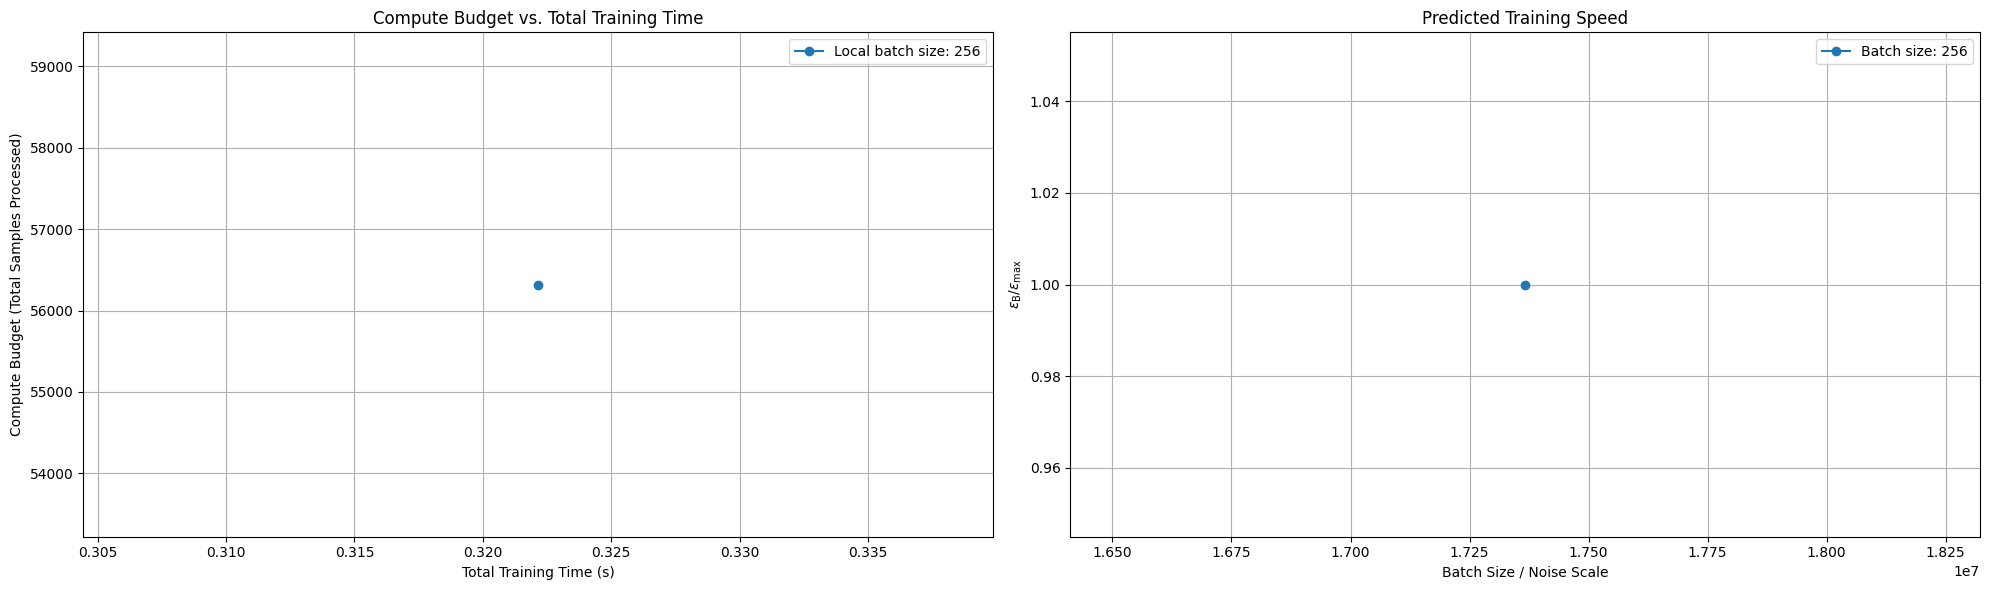

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Bottom-left: Compute Budget vs Training Time
for batch_size, params, hist in total_batch_results:
    times = []
    samples = []
    for round_idx, round_metrics in hist.metrics_distributed_fit['training_time']:
        round_times = [t for _, t in round_metrics['all']]
        times.append(np.mean(round_times))
        
    for round_idx, round_metrics in hist.metrics_distributed_fit['samples_processed']:
        round_samples = [s for _, s in round_metrics['all']]
        samples.append(np.sum(round_samples))
    
    cumulative_time = np.sum(times)
    total_samples = np.sum(samples)
    axes[0].plot(cumulative_time, total_samples, marker='o', label=f"Local batch size: {batch_size}")

axes[0].set_xlabel("Total Training Time (s)")
axes[0].set_ylabel("Compute Budget (Total Samples Processed)")
axes[0].set_title("Compute Budget vs. Total Training Time")
axes[0].legend()
axes[0].grid(True)

# Bottom-right: Noise Scale Analysis
for batch_size, params, hist in total_batch_results:
    noise_scales = []
    for round_idx, round_metrics in hist.metrics_distributed_fit['noise_scale']:
        round_noise_scales = [ns for _, ns in round_metrics['all']]
        noise_scale = np.mean(round_noise_scales)
        noise_scales.append(noise_scale)
    
    avg_noise_scale = np.mean(noise_scales)
    x_axis = batch_size / (avg_noise_scale + 1e-10)
    y_axis = 1 / (1 + (avg_noise_scale / batch_size))
    
    axes[1].plot(x_axis, y_axis, marker='o', label=f"Batch size: {batch_size}")

axes[1].set_xlabel("Batch Size / Noise Scale")
axes[1].set_ylabel(fr"${{\epsilon_\text{{B}}}} / {{\epsilon_\text{{max}}}}$")
axes[1].set_title("Predicted Training Speed")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

varying cohort size

In [17]:
import pickle

def save_experiment(save_file_name, batch_size, parameters_for_each_round, hist):
    """Save experiment results using pickle.
    
    Args:
        save_file_name (str): Path to save the results
        batch_size (int): Batch size used in experiment
        parameters_for_each_round (list): List of model parameters for each round
        hist (History): Flower History object containing metrics
    """
    
    results_dict = {
        'batch_size': batch_size,
        'parameters_for_each_round': parameters_for_each_round,
        'history': hist
    }
    
    with open(save_file_name, 'wb') as f:  # Note: 'wb' for binary write mode
        pickle.dump(results_dict, f)

def load_experiment(file_name):
    """Load experiment results from a pickle file.
    
    Args:
        file_name (str): Path to the results file
        
    Returns:
        tuple: (batch_size, parameters_for_each_round, hist)
    """
    with open(file_name, 'rb') as f:  # Note: 'rb' for binary read mode
        results_dict = pickle.load(f)
    
    return (
        results_dict['batch_size'],
        results_dict['parameters_for_each_round'],
        results_dict['history'],
    )

total_cohort_results = []
cohort_sizes =  [ 5, 10, 20, 50, 75, 100]
for cohort_size in cohort_sizes:
    train_cfg = federated_train_config.copy()
    ratio = np.sqrt(cohort_size / 100)
    train_cfg["client_learning_rate"] = ratio * 0.01
    #train_cfg["max_batches"] = 1000

    test_cfg = federated_test_config.copy()

    parameters_for_each_round, hist = run_simulation(
        num_rounds = 100,
        num_total_clients = num_total_clients,
        num_clients_per_round = cohort_size,
        num_evaluate_clients = num_evaluate_clients,
        min_available_clients = num_total_clients,
        min_fit_clients = cohort_size,
        min_evaluate_clients = num_evaluate_clients,
        evaluate_fn = federated_evaluation_function,
        on_fit_config_fn = lambda _: train_cfg,
        on_evaluate_config_fn = lambda _: test_cfg,
        initial_parameters = initial_parameters,
        fit_metrics_aggregation_fn = aggregate_weighted_average,
        evaluate_metrics_aggregation_fn = aggregate_weighted_average,
        federated_client_generator = federated_client_generator,
        server_learning_rate=server_learning_rate,
        server_momentum=server_momentum,
        accept_failures=accept_failures,
        target_accuracy=0.70,
        use_target_accuracy=True,
        )

    total_cohort_results.append((cohort_size, parameters_for_each_round, hist))
    save_experiment(f"results/iid_federated_cohort_results_{cohort_size}.pkl", cohort_size, parameters_for_each_round=parameters_for_each_round, hist=hist)

INFO flwr 2025-03-15 13:32:36,257 | experiments_simulation.py:200 | FL will execute for 100 rounds
WARNING flwr 2025-03-15 13:32:36,259 | app.py:213 | Both server and strategy were provided, ignoring strategy
INFO flwr 2025-03-15 13:32:36,259 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=100, round_timeout=None)
INFO flwr 2025-03-15 13:32:36,261 | flwr_core.py:264 | Initializing global parameters
INFO flwr 2025-03-15 13:32:36,261 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO flwr 2025-03-15 13:32:36,263 | flwr_core.py:269 | Evaluating initial parameters
 11%|█         | 100/891 [00:00<00:07, 112.09it/s]
INFO flwr 2025-03-15 13:32:37,342 | flwr_core.py:272 | initial parameters (loss, other metrics): 413.6843070983887, {'accuracy': 0.0065625}
INFO flwr 2025-03-15 13:32:37,342 | flwr_core.py:280 | FL starting - Target accuracy: 0.7
DEBUG flwr 2025-03-15 13:32:37,344 | server_returns_parameters.py:223 | fit_round 1: str

5
4
3
3
3
4


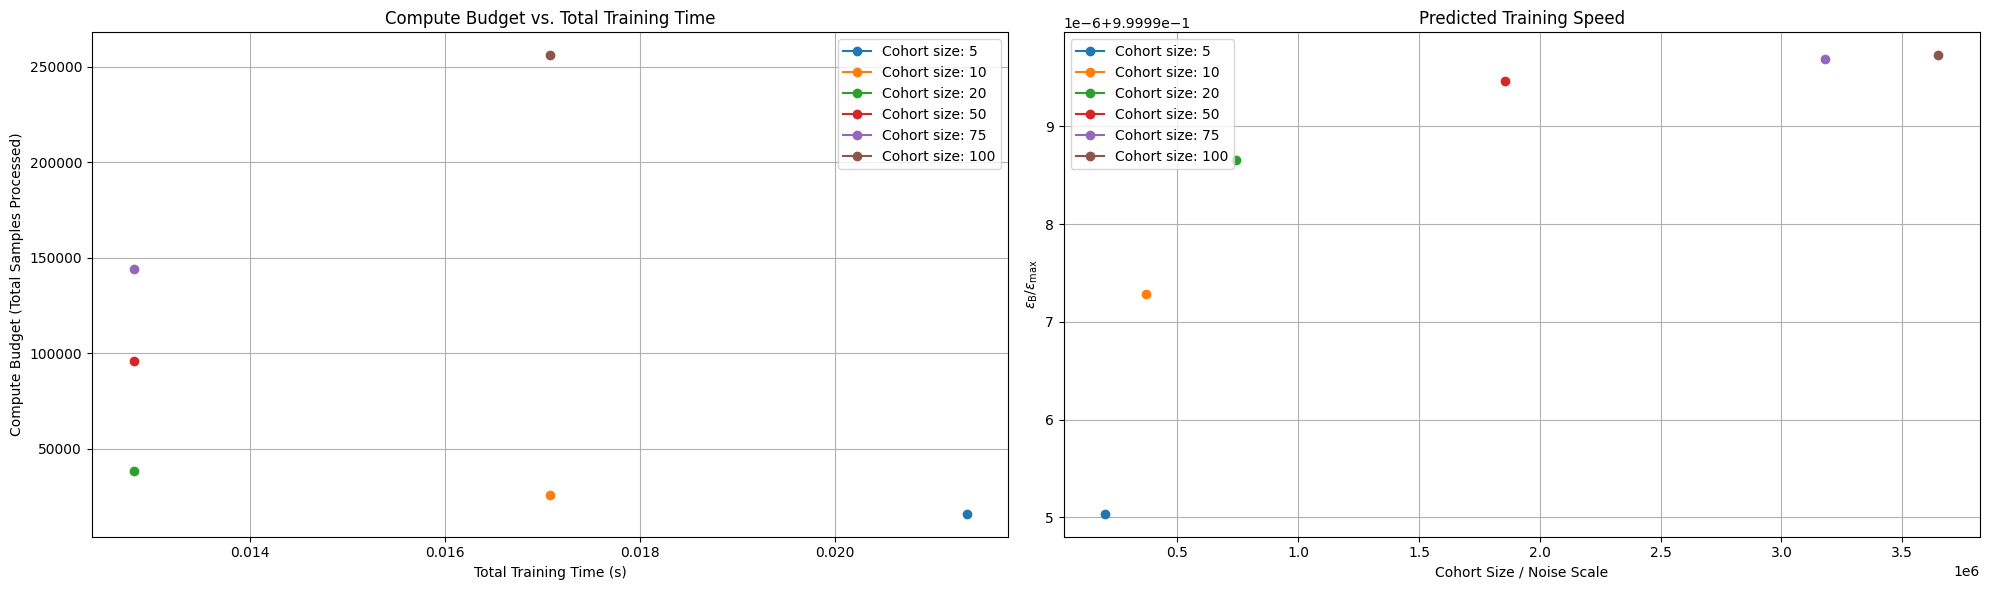

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
time_per_round = 0.00427
# Bottom-left: Compute Budget vs Training Time
for cohort_size, params, hist in total_cohort_results:
    times = []
    samples = []
    num_rounds = len(hist.metrics_distributed_fit['samples_processed'])
    print(num_rounds)
    cumulative_time = num_rounds * time_per_round

    for round_idx, round_metrics in hist.metrics_distributed_fit['samples_processed']:
        round_samples = [s for _, s in round_metrics['all']]
        samples.append(np.sum(round_samples))
    
    
    total_samples = np.sum(samples)
    axes[0].plot(cumulative_time, total_samples, marker='o', label=f"Cohort size: {cohort_size}")

axes[0].set_xlabel("Total Training Time (s)")
axes[0].set_ylabel("Compute Budget (Total Samples Processed)")
axes[0].set_title("Compute Budget vs. Total Training Time")
axes[0].legend()
axes[0].grid(True)

# Bottom-right: Noise Scale Analysis
for cohort_size, params, hist in total_cohort_results:
    noise_scales = []
    for round_idx, round_metrics in hist.metrics_distributed_fit['noise_scale']:
        round_noise_scales = [ns for _, ns in round_metrics['all']]
        noise_scale = np.mean(round_noise_scales)
        noise_scales.append(noise_scale)
    
    avg_noise_scale = np.mean(noise_scales)
    x_axis = cohort_size / (avg_noise_scale + 1e-10)
    y_axis = 1 / (1 + (avg_noise_scale / cohort_size))
    
    axes[1].plot(x_axis, y_axis, marker='o', label=f"Cohort size: {cohort_size}")

axes[1].set_xlabel("Cohort Size / Noise Scale")
axes[1].set_ylabel(fr"${{\epsilon_\text{{B}}}} / {{\epsilon_\text{{max}}}}$")
axes[1].set_title("Predicted Training Speed")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

varying global batch size

In [10]:
time_per_round = 0.00427
times_per_round = [0.003793160191070807, 0.004481774148126263, 0.004956590107499679, 0.004278853300000662]

In [11]:
import pickle

def save_experiment(save_file_name, batch_size, parameters_for_each_round, hist):
    """Save experiment results using pickle.
    
    Args:
        save_file_name (str): Path to save the results
        batch_size (int): Batch size used in experiment
        parameters_for_each_round (list): List of model parameters for each round
        hist (History): Flower History object containing metrics
    """
    
    results_dict = {
        'batch_size': batch_size,
        'parameters_for_each_round': parameters_for_each_round,
        'history': hist
    }
    
    with open(save_file_name, 'wb') as f:  # Note: 'wb' for binary write mode
        pickle.dump(results_dict, f)

def load_experiment(file_name):
    """Load experiment results from a pickle file.
    
    Args:
        file_name (str): Path to the results file
        
    Returns:
        tuple: (batch_size, parameters_for_each_round, hist)
    """
    with open(file_name, 'rb') as f:  # Note: 'rb' for binary read mode
        results_dict = pickle.load(f)
    
    return (
        results_dict['batch_size'],
        results_dict['parameters_for_each_round'],
        results_dict['history'],
    )

total_global_batch_results = []
cs_bs_pairs = [(5, 20), (20, 50), (50, 200), (100, 250), (100, 1000), (100, 2000), (100, 4000), (100, 12000)]
for cohort_size, batch_size in cs_bs_pairs:
    global_batch_size = batch_size * cohort_size
    train_cfg = federated_train_config.copy()
    ratio = np.sqrt(cohort_size * batch_size / 1e6)
    # ratio = 100 / 100 = 1 * 0.01
    # if i multiply by batch size, i want to divide
    print("----------------------------------------------------------", ratio * 0.01)
    train_cfg["client_learning_rate"] = ratio * 0.01
    #train_cfg["max_batches"] = 1000

    test_cfg = federated_test_config.copy()

    parameters_for_each_round, hist = run_simulation(
        num_rounds = 100,
        num_total_clients = num_total_clients,
        num_clients_per_round = cohort_size,
        num_evaluate_clients = num_evaluate_clients,
        min_available_clients = num_total_clients,
        min_fit_clients = cohort_size,
        min_evaluate_clients = num_evaluate_clients,
        evaluate_fn = federated_evaluation_function,
        on_fit_config_fn = lambda _: train_cfg,
        on_evaluate_config_fn = lambda _: test_cfg,
        initial_parameters = initial_parameters,
        fit_metrics_aggregation_fn = aggregate_weighted_average,
        evaluate_metrics_aggregation_fn = aggregate_weighted_average,
        federated_client_generator = federated_client_generator,
        server_learning_rate=server_learning_rate,
        server_momentum=server_momentum,
        accept_failures=accept_failures,
        target_accuracy=0.70,
        use_target_accuracy=True,
        )

    total_global_batch_results.append((global_batch_size, parameters_for_each_round, hist))
    save_experiment(f"results/iid_federated_global_batch_results_{global_batch_size}.pkl", global_batch_size, parameters_for_each_round=parameters_for_each_round, hist=hist)

INFO flwr 2025-03-15 15:00:41,117 | experiments_simulation.py:200 | FL will execute for 100 rounds
WARNING flwr 2025-03-15 15:00:41,121 | app.py:213 | Both server and strategy were provided, ignoring strategy
INFO flwr 2025-03-15 15:00:41,122 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=100, round_timeout=None)
INFO flwr 2025-03-15 15:00:41,123 | flwr_core.py:264 | Initializing global parameters
INFO flwr 2025-03-15 15:00:41,124 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO flwr 2025-03-15 15:00:41,125 | flwr_core.py:269 | Evaluating initial parameters


---------------------------------------------------------- 0.0001


 11%|█         | 100/891 [00:02<00:21, 36.91it/s]
INFO flwr 2025-03-15 15:00:44,314 | flwr_core.py:272 | initial parameters (loss, other metrics): 413.6843070983887, {'accuracy': 0.0065625}
INFO flwr 2025-03-15 15:00:44,315 | flwr_core.py:280 | FL starting - Target accuracy: 0.7
DEBUG flwr 2025-03-15 15:00:44,315 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 5 clients (out of 100)
INFO flwr 2025-03-15 15:00:44,316 | flwr_core.py:107 | cid: 985
INFO flwr 2025-03-15 15:00:44,319 | flwr_core.py:107 | cid: 68
INFO flwr 2025-03-15 15:00:44,320 | flwr_core.py:107 | cid: 291
INFO flwr 2025-03-15 15:00:44,322 | flwr_core.py:107 | cid: 852
INFO flwr 2025-03-15 15:00:44,323 | flwr_core.py:107 | cid: 993
DEBUG flwr 2025-03-15 15:00:57,060 | server_returns_parameters.py:237 | fit_round 1 received 5 results and 0 failures
 11%|█         | 100/891 [00:02<00:17, 44.86it/s]
INFO flwr 2025-03-15 15:00:59,496 | flwr_core.py:303 | fit progress: (round 1, accuracy 0.079375, loss 355.5

---------------------------------------------------------- 0.00031622776601683794


 11%|█         | 100/891 [00:02<00:17, 43.98it/s]
INFO flwr 2025-03-15 15:20:41,891 | flwr_core.py:272 | initial parameters (loss, other metrics): 413.6843070983887, {'accuracy': 0.0065625}
INFO flwr 2025-03-15 15:20:41,892 | flwr_core.py:280 | FL starting - Target accuracy: 0.7
DEBUG flwr 2025-03-15 15:20:41,894 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 20 clients (out of 100)
INFO flwr 2025-03-15 15:20:41,895 | flwr_core.py:107 | cid: 985
INFO flwr 2025-03-15 15:20:41,897 | flwr_core.py:107 | cid: 68
INFO flwr 2025-03-15 15:20:41,899 | flwr_core.py:107 | cid: 291
INFO flwr 2025-03-15 15:20:41,902 | flwr_core.py:107 | cid: 852
INFO flwr 2025-03-15 15:20:41,903 | flwr_core.py:107 | cid: 993
INFO flwr 2025-03-15 15:20:41,905 | flwr_core.py:107 | cid: 591
INFO flwr 2025-03-15 15:20:41,905 | flwr_core.py:107 | cid: 767
INFO flwr 2025-03-15 15:20:41,907 | flwr_core.py:107 | cid: 779
INFO flwr 2025-03-15 15:20:41,908 | flwr_core.py:107 | cid: 814
INFO flwr 2025-03-1

---------------------------------------------------------- 0.001


 11%|█         | 100/891 [00:02<00:17, 45.92it/s]
INFO flwr 2025-03-15 15:48:23,857 | flwr_core.py:272 | initial parameters (loss, other metrics): 413.6843070983887, {'accuracy': 0.0065625}
INFO flwr 2025-03-15 15:48:23,858 | flwr_core.py:280 | FL starting - Target accuracy: 0.7
DEBUG flwr 2025-03-15 15:48:23,860 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 50 clients (out of 100)
INFO flwr 2025-03-15 15:48:23,862 | flwr_core.py:107 | cid: 985
INFO flwr 2025-03-15 15:48:23,865 | flwr_core.py:107 | cid: 68
INFO flwr 2025-03-15 15:48:23,867 | flwr_core.py:107 | cid: 291
INFO flwr 2025-03-15 15:48:23,869 | flwr_core.py:107 | cid: 852
INFO flwr 2025-03-15 15:48:23,871 | flwr_core.py:107 | cid: 993
INFO flwr 2025-03-15 15:48:23,871 | flwr_core.py:107 | cid: 591
INFO flwr 2025-03-15 15:48:23,874 | flwr_core.py:107 | cid: 767
INFO flwr 2025-03-15 15:48:23,877 | flwr_core.py:107 | cid: 779
INFO flwr 2025-03-15 15:48:23,878 | flwr_core.py:107 | cid: 819
INFO flwr 2025-03-1

---------------------------------------------------------- 0.0015811388300841897


 11%|█         | 100/891 [00:02<00:19, 40.60it/s]
INFO flwr 2025-03-15 16:13:02,960 | flwr_core.py:272 | initial parameters (loss, other metrics): 413.6843070983887, {'accuracy': 0.0065625}
INFO flwr 2025-03-15 16:13:02,960 | flwr_core.py:280 | FL starting - Target accuracy: 0.7
DEBUG flwr 2025-03-15 16:13:02,963 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 100 clients (out of 100)
INFO flwr 2025-03-15 16:13:02,964 | flwr_core.py:107 | cid: 985
INFO flwr 2025-03-15 16:13:02,965 | flwr_core.py:107 | cid: 68
INFO flwr 2025-03-15 16:13:02,967 | flwr_core.py:107 | cid: 291
INFO flwr 2025-03-15 16:13:02,969 | flwr_core.py:107 | cid: 852
INFO flwr 2025-03-15 16:13:02,970 | flwr_core.py:107 | cid: 993
INFO flwr 2025-03-15 16:13:02,971 | flwr_core.py:107 | cid: 591
INFO flwr 2025-03-15 16:13:02,975 | flwr_core.py:107 | cid: 767
INFO flwr 2025-03-15 16:13:02,980 | flwr_core.py:107 | cid: 779
INFO flwr 2025-03-15 16:13:02,982 | flwr_core.py:107 | cid: 819
INFO flwr 2025-03-

---------------------------------------------------------- 0.0031622776601683794


 11%|█         | 100/891 [00:01<00:13, 59.58it/s]
INFO flwr 2025-03-15 16:45:10,144 | flwr_core.py:272 | initial parameters (loss, other metrics): 413.6843070983887, {'accuracy': 0.0065625}
INFO flwr 2025-03-15 16:45:10,145 | flwr_core.py:280 | FL starting - Target accuracy: 0.7
DEBUG flwr 2025-03-15 16:45:10,148 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 100 clients (out of 100)
INFO flwr 2025-03-15 16:45:10,149 | flwr_core.py:107 | cid: 985
INFO flwr 2025-03-15 16:45:10,151 | flwr_core.py:107 | cid: 68
INFO flwr 2025-03-15 16:45:10,153 | flwr_core.py:107 | cid: 291
INFO flwr 2025-03-15 16:45:10,154 | flwr_core.py:107 | cid: 852
INFO flwr 2025-03-15 16:45:10,155 | flwr_core.py:107 | cid: 993
INFO flwr 2025-03-15 16:45:10,157 | flwr_core.py:107 | cid: 591
INFO flwr 2025-03-15 16:45:10,159 | flwr_core.py:107 | cid: 767
INFO flwr 2025-03-15 16:45:10,162 | flwr_core.py:107 | cid: 779
INFO flwr 2025-03-15 16:45:10,162 | flwr_core.py:107 | cid: 819
INFO flwr 2025-03-

---------------------------------------------------------- 0.00447213595499958


 11%|█         | 100/891 [00:02<00:17, 44.46it/s]
INFO flwr 2025-03-15 17:03:08,620 | flwr_core.py:272 | initial parameters (loss, other metrics): 413.6843070983887, {'accuracy': 0.0065625}
INFO flwr 2025-03-15 17:03:08,621 | flwr_core.py:280 | FL starting - Target accuracy: 0.7
DEBUG flwr 2025-03-15 17:03:08,623 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 100 clients (out of 100)
INFO flwr 2025-03-15 17:03:08,625 | flwr_core.py:107 | cid: 985
INFO flwr 2025-03-15 17:03:08,626 | flwr_core.py:107 | cid: 68
INFO flwr 2025-03-15 17:03:08,630 | flwr_core.py:107 | cid: 291
INFO flwr 2025-03-15 17:03:08,631 | flwr_core.py:107 | cid: 852
INFO flwr 2025-03-15 17:03:08,634 | flwr_core.py:107 | cid: 993
INFO flwr 2025-03-15 17:03:08,637 | flwr_core.py:107 | cid: 591
INFO flwr 2025-03-15 17:03:08,640 | flwr_core.py:107 | cid: 767
INFO flwr 2025-03-15 17:03:08,642 | flwr_core.py:107 | cid: 779
INFO flwr 2025-03-15 17:03:08,644 | flwr_core.py:107 | cid: 819
INFO flwr 2025-03-

---------------------------------------------------------- 0.006324555320336759


 11%|█         | 100/891 [00:01<00:15, 50.21it/s]
INFO flwr 2025-03-15 17:16:41,690 | flwr_core.py:272 | initial parameters (loss, other metrics): 413.6843070983887, {'accuracy': 0.0065625}
INFO flwr 2025-03-15 17:16:41,691 | flwr_core.py:280 | FL starting - Target accuracy: 0.7
DEBUG flwr 2025-03-15 17:16:41,694 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 100 clients (out of 100)
INFO flwr 2025-03-15 17:16:41,695 | flwr_core.py:107 | cid: 985
INFO flwr 2025-03-15 17:16:41,698 | flwr_core.py:107 | cid: 68
INFO flwr 2025-03-15 17:16:41,701 | flwr_core.py:107 | cid: 291
INFO flwr 2025-03-15 17:16:41,702 | flwr_core.py:107 | cid: 852
INFO flwr 2025-03-15 17:16:41,704 | flwr_core.py:107 | cid: 993
INFO flwr 2025-03-15 17:16:41,705 | flwr_core.py:107 | cid: 591
INFO flwr 2025-03-15 17:16:41,706 | flwr_core.py:107 | cid: 767
INFO flwr 2025-03-15 17:16:41,709 | flwr_core.py:107 | cid: 779
INFO flwr 2025-03-15 17:16:41,711 | flwr_core.py:107 | cid: 819
INFO flwr 2025-03-

---------------------------------------------------------- 0.01095445115010332


 11%|█         | 100/891 [00:01<00:13, 56.50it/s]
INFO flwr 2025-03-15 17:30:11,975 | flwr_core.py:272 | initial parameters (loss, other metrics): 413.6843070983887, {'accuracy': 0.0065625}
INFO flwr 2025-03-15 17:30:11,976 | flwr_core.py:280 | FL starting - Target accuracy: 0.7
DEBUG flwr 2025-03-15 17:30:11,979 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 100 clients (out of 100)
INFO flwr 2025-03-15 17:30:11,980 | flwr_core.py:107 | cid: 985
INFO flwr 2025-03-15 17:30:11,981 | flwr_core.py:107 | cid: 68
INFO flwr 2025-03-15 17:30:11,983 | flwr_core.py:107 | cid: 291
INFO flwr 2025-03-15 17:30:11,984 | flwr_core.py:107 | cid: 852
INFO flwr 2025-03-15 17:30:11,986 | flwr_core.py:107 | cid: 993
INFO flwr 2025-03-15 17:30:11,987 | flwr_core.py:107 | cid: 591
INFO flwr 2025-03-15 17:30:11,988 | flwr_core.py:107 | cid: 767
INFO flwr 2025-03-15 17:30:11,990 | flwr_core.py:107 | cid: 779
INFO flwr 2025-03-15 17:30:11,991 | flwr_core.py:107 | cid: 819
INFO flwr 2025-03-

/tmp/ipykernel_295791/1130611999.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()
/tmp/ipykernel_295791/1130611999.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


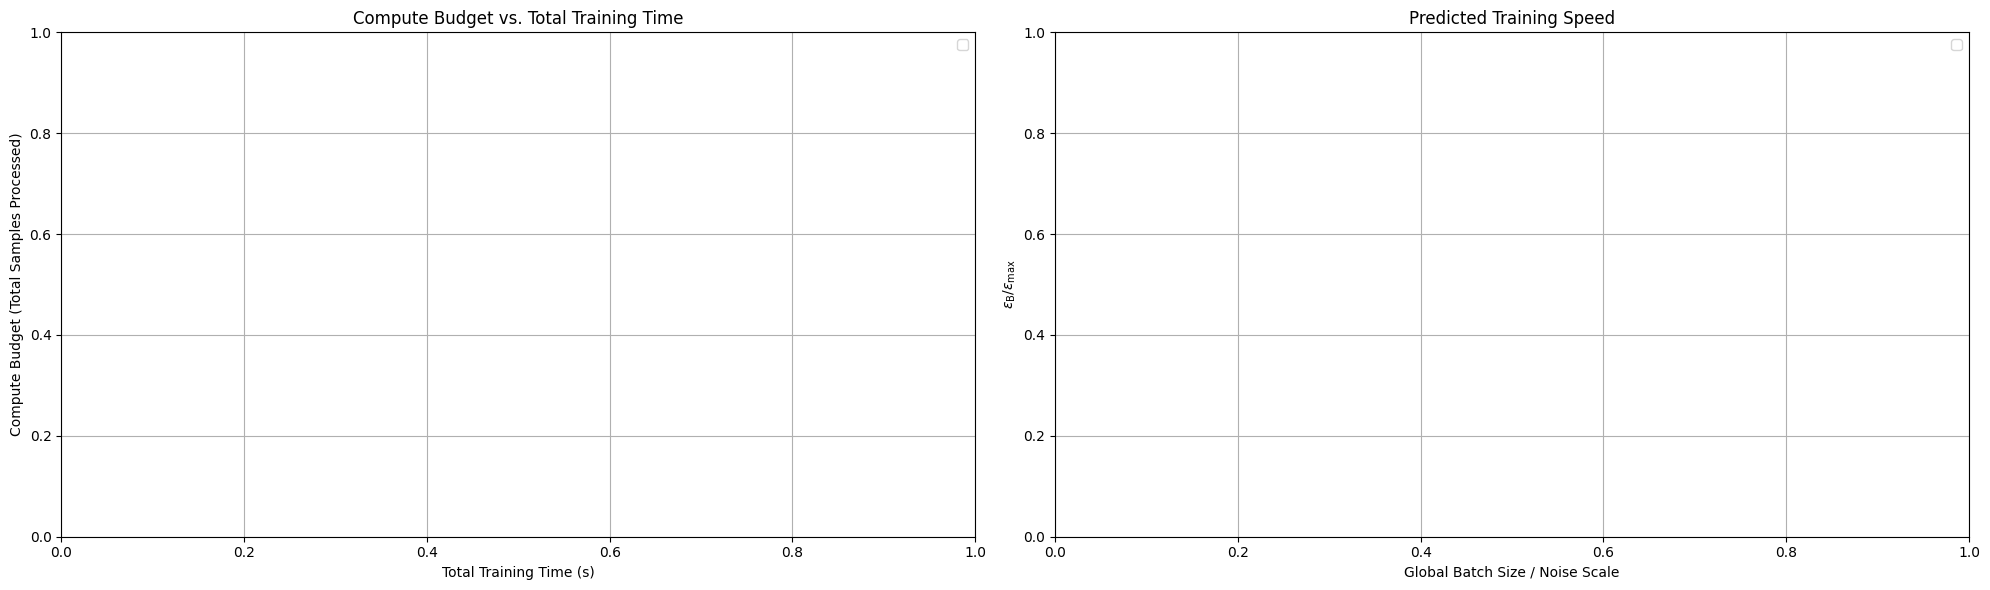

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Bottom-left: Compute Budget vs Training Time
for global_batch_size, params, hist in total_global_batch_results:
    times = []
    samples = []
    num_rounds = len(hist.metrics_distributed_fit['samples_processed'])
    print(num_rounds)
    cumulative_time = num_rounds * time_per_round

    for round_idx, round_metrics in hist.metrics_distributed_fit['samples_processed']:
        round_samples = [s for _, s in round_metrics['all']]
        samples.append(np.sum(round_samples))
    
    
    total_samples = np.sum(samples)
    axes[0].plot(cumulative_time, total_samples, marker='o', label=f"Global batch size: {global_batch_size}")

axes[0].set_xlabel("Total Training Time (s)")
axes[0].set_ylabel("Compute Budget (Total Samples Processed)")
axes[0].set_title("Compute Budget vs. Total Training Time")
axes[0].legend()
axes[0].grid(True)

# Bottom-right: Noise Scale Analysis
for global_batch_size, params, hist in total_global_batch_results:
    noise_scales = []
    for round_idx, round_metrics in hist.metrics_distributed_fit['noise_scale']:
        round_noise_scales = [ns for _, ns in round_metrics['all']]
        noise_scale = np.mean(round_noise_scales)
        noise_scales.append(noise_scale)
    
    avg_noise_scale = np.mean(noise_scales)
    x_axis = global_batch_size / (avg_noise_scale + 1e-10)
    y_axis = 1 / (1 + (avg_noise_scale / global_batch_size))
    
    axes[1].plot(x_axis, y_axis, marker='o', label=f"Global batch size: {global_batch_size}")

axes[1].set_xlabel("Global Batch Size / Noise Scale")
axes[1].set_ylabel(fr"${{\epsilon_\text{{B}}}} / {{\epsilon_\text{{max}}}}$")
axes[1].set_title("Predicted Training Speed")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()